# DTW analysis in the embedding layer of the CNN model
Henry D. Chacon, henrychacon@gmail.com

## Abstract

The convolution neural network models mimic the image detection process followed by mammals. Where each image is decomposed in a specific signature or signal. In this report, the popular LeNet-5 model is trained with the NMIST data set to measure the signal separation in the embedding layer between each category in the data set by using the DTW distance.


## Embedding layer representation

Any CNN model can we devided in two sections. In the first one, image features are extracted through several stack layers of convolution operations given by:

$$f_S(t) = f_W(t) * f_X(t)=\int_{-\infty}^{\infty} f_W(t-x)f_X(x)dx$$
if $X$ and $W$ are independent random variables, the probability density function of the random variable $S$ defined by $S=W+X$ is given by the convolution of the individual densities of $X$ and $W$.

The output of the convolution layer is flatted in the embedding layer and send it to a fully connected layer for classification, as it is described in the following image:

<img src="CNN_model.jpg" width="600">

## Experimental process followed

1. Training a LeNet-5 model using the NMIST data set
2. Generating the most "typical" sequence in the embedding layer per category. Which is, the median value of all the images signals in the embedding layer per category.
3. Computing the signal's separation between categories by using the DTW distance. 

## Python implementation
###  Step 1: training a LeNet-5 model using the MNIST data set

In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torchsummary import summary
from torchvision import datasets, transforms
import time
import numpy as np
import pandas as pd
import math
import seaborn as sns
from operator import add

Hyperparameters definitions:

In [2]:
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

Downloading the data set, then images are packed in blocks (or batches) based on the parameter defined above in order to reduce the computation load.

In [3]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=trans, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=trans, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
print('Images for training: {}, images for testing: {}'.format(len(train_dataset), len(test_dataset)))

Images for training: 60000, images for testing: 10000


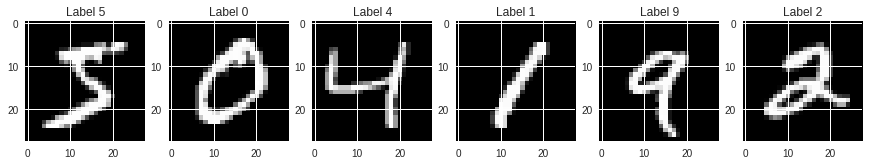

In [4]:
# Figures display example
fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1, 6, i+1)
    sample_image, sample_target = train_dataset[i]
    sample_image = torch.squeeze(sample_image).numpy()
    plt.imshow(sample_image, cmap='gray')
    plt.title('Label {}'.format(sample_target))

CNN model and optimization definition:

In [5]:
class ConvNet(nn.Module):
    def __init__(self, parallel = False):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        if parallel:
            self.layer1 = nn.DataParallel(self.layer1)
            self.layer2 = nn.DataParallel(self.layer2)
    
        self.dropout = nn.Dropout()
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
    
    # Function to print out the intermediate values for an input image
    def return_steps(self, x):
        cnv1 = self.layer1(x)
        cnv2 = self.layer2(cnv1)
        cnv3 = cnv2.reshape(cnv2.size(0), -1)
        lfc1 = self.fc1(cnv3)
        lfc2 = self.fc2(lfc1)
        lfc3 = self.fc3(lfc2)
        return cnv1, cnv2, cnv3, lfc1, lfc2, lfc3

model = ConvNet()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.is_available():
    model.cuda()
    
# Loss and optimization
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
summary(model, (1, 28, 28), 1, device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [1, 6, 24, 24]             156
         MaxPool2d-2             [1, 6, 12, 12]               0
            Conv2d-3              [1, 16, 8, 8]           2,416
         MaxPool2d-4              [1, 16, 4, 4]               0
           Dropout-5                   [1, 256]               0
            Linear-6                   [1, 120]          30,840
            Linear-7                   [1, 100]          12,100
            Linear-8                    [1, 10]           1,010
Total params: 46,522
Trainable params: 46,522
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.18
Estimated Total Size (MB): 0.23
----------------------------------------------------------------


Training the model and test validation:

In [7]:
time_start = time.time()
# Training the model
total_step, loss_list, acc_list = len(train_loader), [], []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Run the forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Tracking the accuracy
        total = float(labels.size(0))
        _, predicted = torch.max(outputs.data, 1)
        correct = torch.sum(predicted == labels).item()
        acc_list.append(correct / total)

        if (i + 1) % 600 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), (correct / total) * 100))

# time_end = datetime.datetime.now()
# time_delta = time_end - time_start
print('Training time (in seconds): {:.2f}'.format(time.time() - time_start))

Epoch [1/5], Step [600/600], Loss: 0.3506, Accuracy: 93.00%
Epoch [2/5], Step [600/600], Loss: 0.3120, Accuracy: 97.00%
Epoch [3/5], Step [600/600], Loss: 0.3816, Accuracy: 97.00%
Epoch [4/5], Step [600/600], Loss: 0.3090, Accuracy: 98.00%
Epoch [5/5], Step [600/600], Loss: 0.3336, Accuracy: 98.00%
Training time (in seconds): 30.94


Getting the flatten layer values for the trainig set

In [8]:
sample_size = 10
num_val = np.zeros(sample_size)
sequences = {}
for j in range(len(train_dataset)):
    out = model.return_steps(torch.reshape(train_dataset[j][0], [1, 1, 28, 28]).to(device))
    label = train_dataset[j][1]
    lab_col = str(int(num_val[label]))
    if label in sequences:
        df = pd.DataFrame(out[2].detach().t().cpu().numpy(), columns=[lab_col])
        sequences[label][lab_col] = df
    else:
        sequences[label] = pd.DataFrame(out[2].detach().t().cpu().numpy(), columns=[lab_col])
    num_val[label] += 1

Computing the median value per element in the flatten layer:

In [9]:
median_train_orig = pd.DataFrame()
for i in range(10):
    median_train_orig[str(i)] = sequences[i].median(1)

Text(0.5,1,'Output distribution for the node 40 and digit 0 in the embedding layer. In red, the median and green the mean')

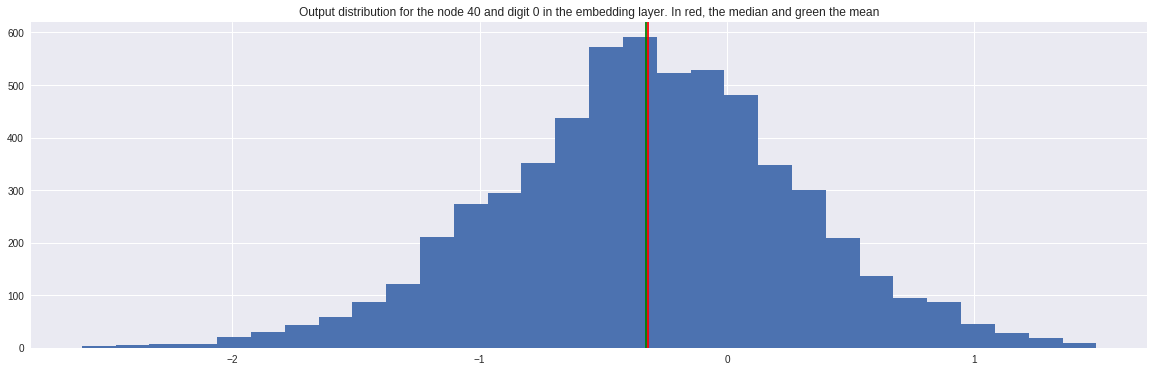

In [10]:
digit = 0
elmnt = 40
fig = plt.figure(figsize=(20, 6))
plt.hist(sequences[digit].loc[elmnt], bins=30)
plt.axvline(x=median_train_orig.iloc[elmnt, digit], color='red')
plt.axvline(x=sequences[digit].loc[elmnt].mean(), color='green')
plt.title('Output distribution for the node {} and digit {} in the embedding layer. In red, the median and green the mean'.format(elmnt, digit))

Median signature representation per digit

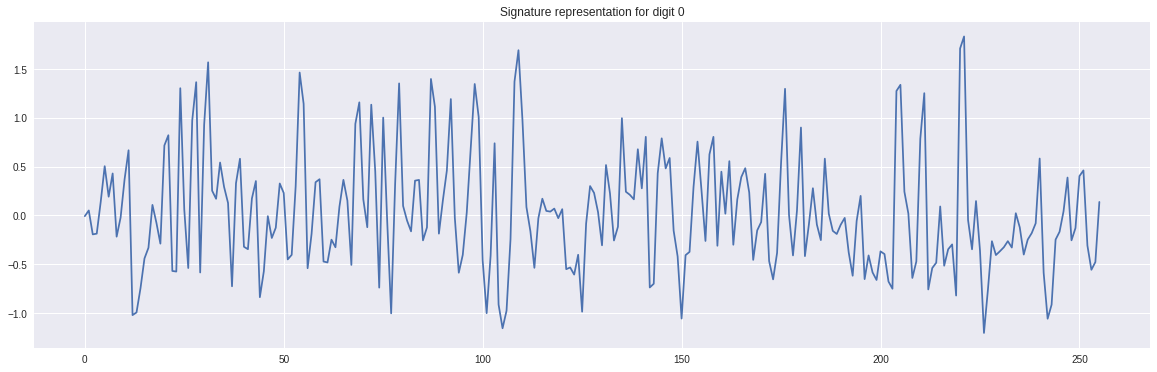

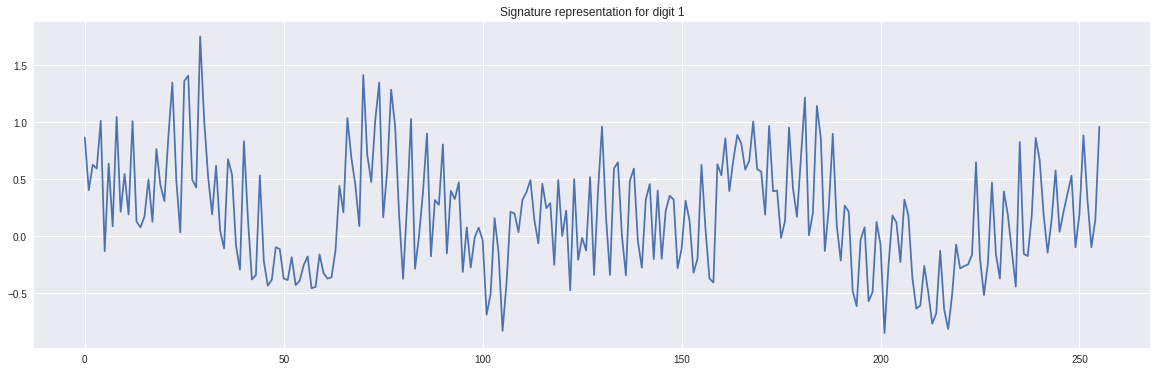

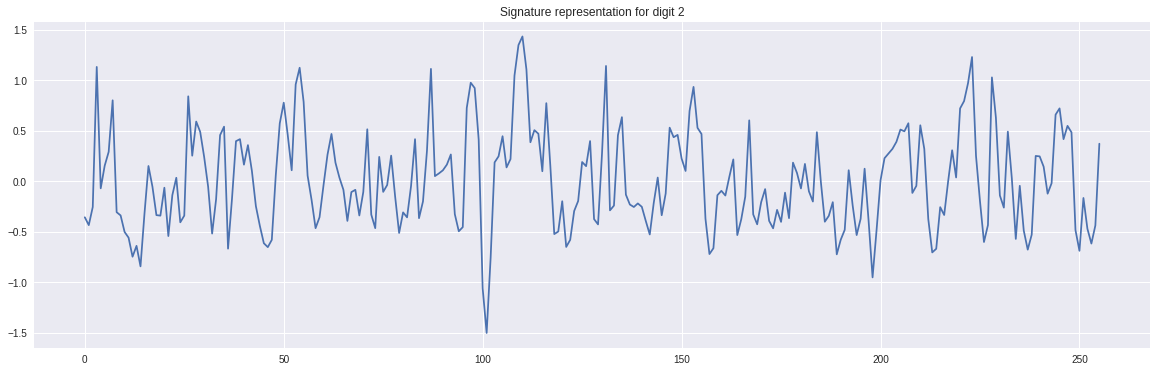

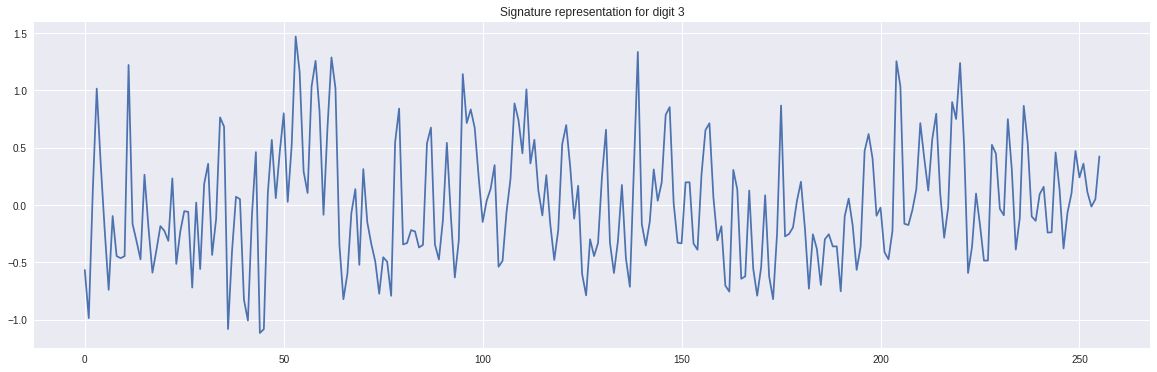

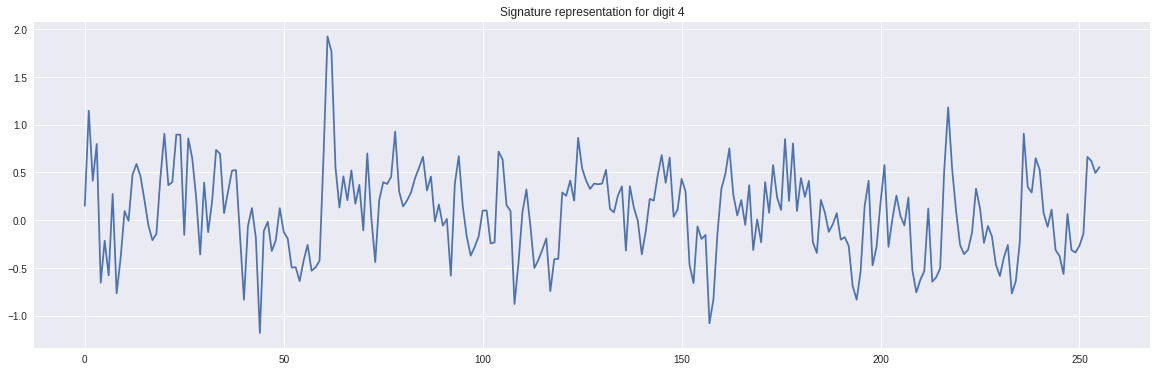

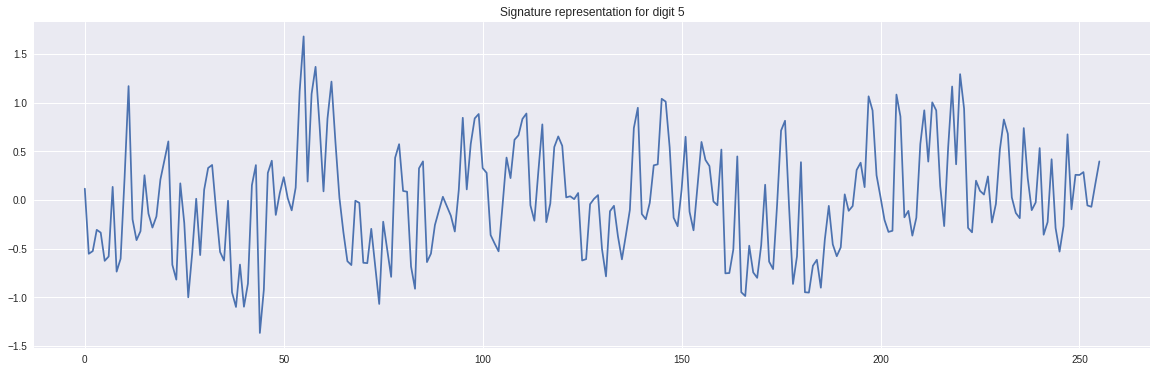

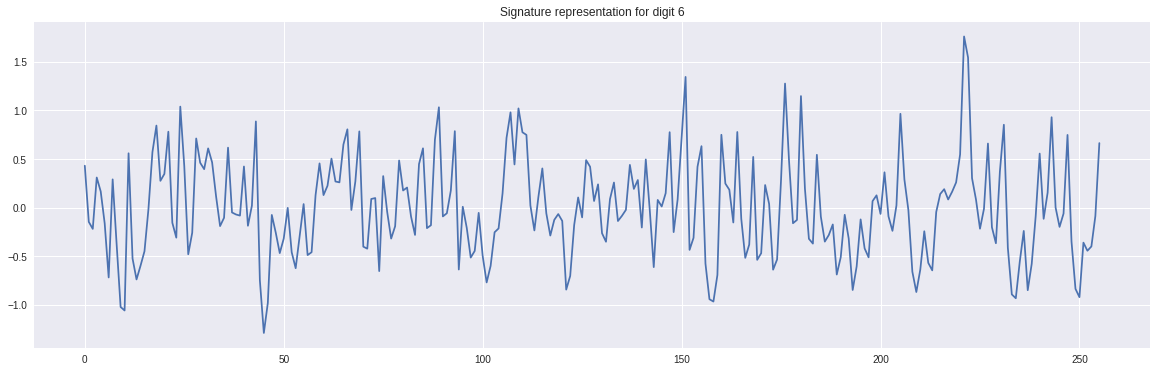

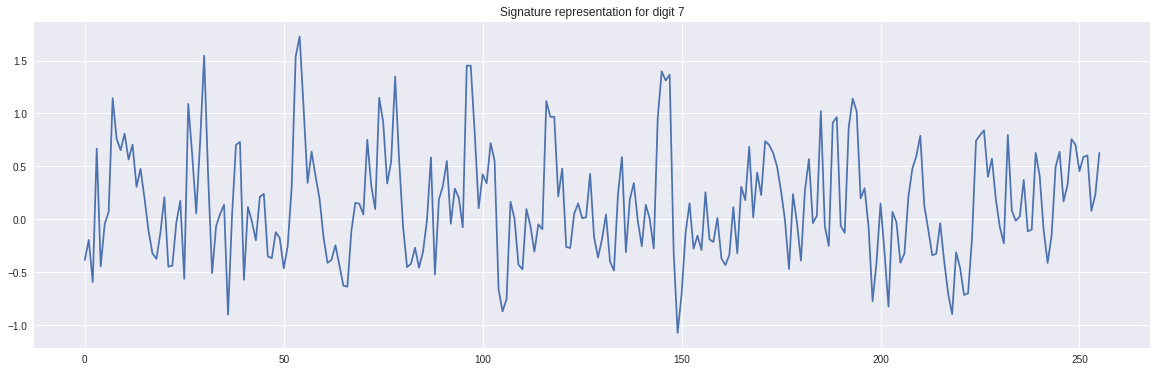

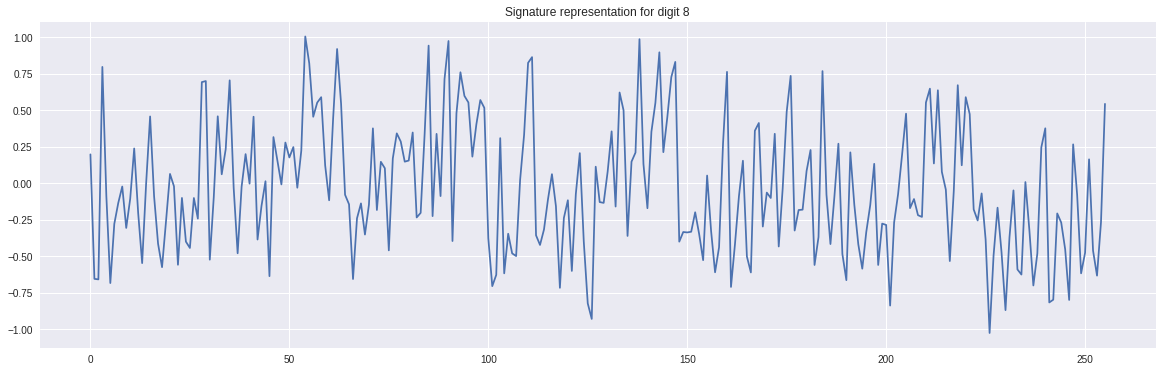

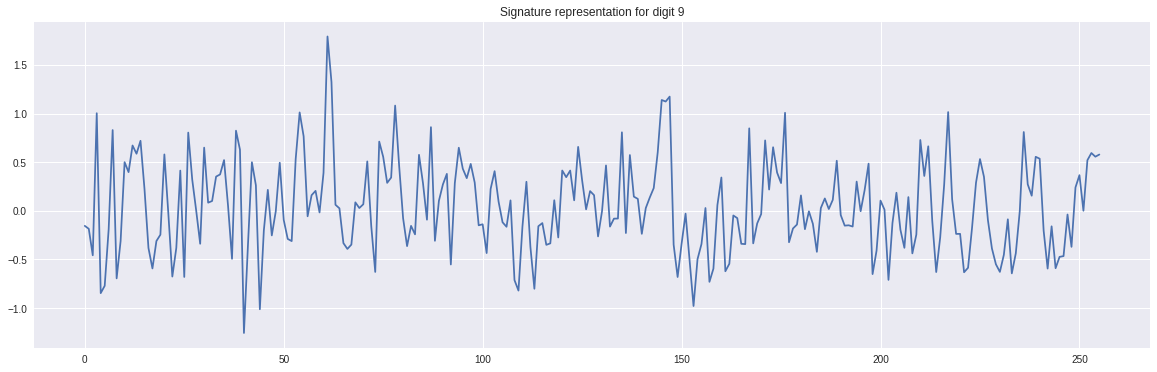

In [11]:
for i in range(10):
    fig = plt.figure(figsize=(20, 6))
    plt.plot(np.arange(256), median_train_orig.iloc[0:256, i])
    plt.title('Signature representation for digit {}'.format(i))

In [12]:
from dtw import dtw
absolute_norm = lambda x, y: np.abs(x - y)
euclidean_norm = lambda x, y: (x - y)**2

In [13]:
distance_median_euclidian = np.zeros((10, 10))
distance_median_abolute = np.zeros((10, 10))
for i in range(10):
#     print('Values for digit {}'.format(i))
    for j in range(i, 10):
        distance_median_euclidian[i, j] = dtw(median_train_orig.iloc[0:256, i], median_train_orig.iloc[0:256, j], dist=euclidean_norm)[0]
        distance_median_euclidian[j, i] = distance_median_euclidian[i, j]
        distance_median_abolute[i, j] = dtw(median_train_orig.iloc[0:256, i], median_train_orig.iloc[0:256, j], dist=absolute_norm)[0]
        distance_median_abolute[j, i] = distance_median_abolute[i, j]

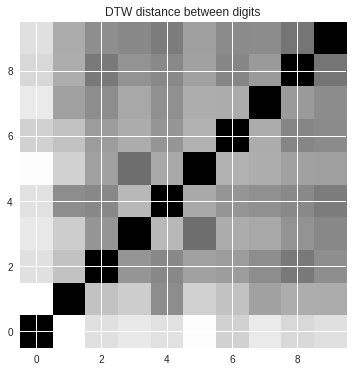

In [14]:
fig = plt.figure(figsize=(20, 6))
plt.imshow(distance_median_euclidian, origin='lower', cmap='gray', interpolation='nearest')
plt.title('DTW distance between digits')
plt.show()

In the following section, the first then elements in the sample test are sent in the model to get the embedding layer. Then, the DTW distance is computed using as reference the median series per label

DTW distance for the first ten items in the testing set. Columns: DTW using as reference the median per category in th embedding layer


,0,1,2,3,4,5,6,7,8,9
Label 7,0.089631,0.093829,0.089315,0.084634,0.080913,0.100497,0.090936,0.045214,0.100198,0.080607
Label 2,0.104090,0.137893,0.101487,0.107729,0.115275,0.118307,0.104192,0.108125,0.116267,0.117775
Label 1,0.090921,0.017351,0.063992,0.070902,0.047945,0.069865,0.067130,0.053925,0.057821,0.063864
Label 0,0.093914,0.190776,0.164729,0.160845,0.180921,0.176082,0.158138,0.170647,0.162226,0.163341
Label 4,0.080137,0.084278,0.088615,0.085300,0.060234,0.087779,0.090744,0.084072,0.085443,0.076427
Label 1,0.102458,0.025112,0.091410,0.091083,0.070123,0.090062,0.088127,0.077063,0.087206,0.083837
Label 4,0.078480,0.095131,0.087844,0.083572,0.073675,0.089646,0.091013,0.083507,0.090174,0.072789
Label 9,0.130157,0.165226,0.138537,0.131507,0.147086,0.134420,0.133387,0.134044,0.128571,0.126364
Label 5,0.157482,0.205648,0.171221,0.170788,0.188011,0.171938,0.162655,0.167646,0.180366,0.180879
Label 9,0.111316,0.150199,0.123954,0.104722,0.135255,0.110818,0.115409,0.109783,0.130566,0.114930


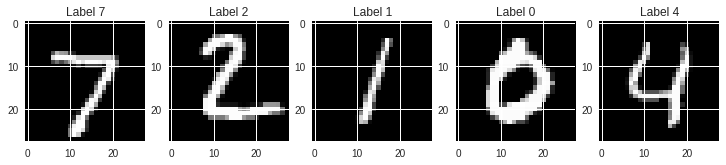

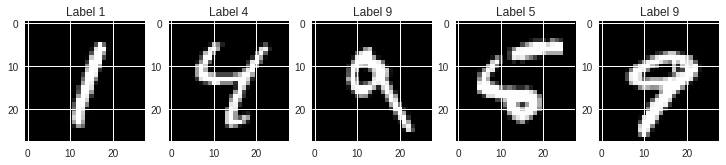

In [15]:
dist_comparison = pd.DataFrame()
prediction_errors = {}
model.eval()
with torch.no_grad():
    correct = 0
    total = float(0)
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model.return_steps(images)
        break
        
    test_number = 10
    for out_id in range(test_number):
        dst = {}
        for i in range(10):
            dst[i] = dtw(median_train_orig.iloc[:, i], outputs[2][out_id].cpu().numpy(), dist=euclidean_norm)[0]
        dist_comparison = dist_comparison.append(pd.DataFrame(dst, index=['Label {}'.format(labels[out_id].item())]))
        
    print('DTW distance for the first ten items in the testing set. Columns: DTW using as reference the median per category in th embedding layer')
    display(dist_comparison)
    
    # Figures display example
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        plt.subplot(1, 6, i+1)
        sample_image, sample_target = test_dataset[i]
        sample_image = torch.squeeze(sample_image).numpy()
        plt.imshow(sample_image, cmap='gray')
        plt.title('Label {}'.format(sample_target))
        
    # Figures display example
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        plt.subplot(1, 6, i+1)
        sample_image, sample_target = test_dataset[i + 5]
        sample_image = torch.squeeze(sample_image).numpy()
        plt.imshow(sample_image, cmap='gray')
        plt.title('Label {}'.format(sample_target))

In [16]:
model.eval()
with torch.no_grad():
    correct = 0
    total = float(0)
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        break

cnn_dtw_comp = pd.DataFrame(dist_comparison.idxmin(axis=1), columns=['DTW median distance'])
cnn_dtw_comp.insert(loc=1, column='CNN output', value=predicted[0:10].cpu().numpy())
display(cnn_dtw_comp)

,DTW median distance,CNN output
Label 7,7,7
Label 2,2,2
Label 1,1,1
Label 0,0,0
Label 4,4,4
Label 1,1,1
Label 4,9,4
Label 9,9,9
Label 5,0,5
Label 9,3,9


**Conclusion:** The fully connected layer is comparing a boundary of values per category and not a point estimate sequence per label category such as the median value

## Poisoned attack comparison

In this case, the initial test accuracy is tested based on the testing set. Then, a new model will be trained using as a testing set, attacked images per category

In [22]:
test_accuracy = {}
test_accuracy_label = {}
model.eval()
with torch.no_grad():
    correct = 0
    total = float(0)
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  
        
        for i in range(10):
            if i in test_accuracy_label.keys():
                st = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_label[i] = list(map(add, st, test_accuracy_label[i]))
            else:
                test_accuracy_label[i] = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
        
        
    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))
    test_accuracy['Clean'] = (correct / total) * 100

    print('Accuracy per label:')
    df_acc_cmp = pd.DataFrame(100*pd.DataFrame(test_accuracy_label).iloc[1, :]/pd.DataFrame(test_accuracy_label).iloc[0, :], columns=['Original accuracy']).transpose()
    display(df_acc_cmp)

Test Accuracy of the model on the 10000 test images: 97.69 %
Accuracy per label:


,0,1,2,3,4,5,6,7,8,9
Original accuracy,98.77551,99.559471,96.608527,97.029703,97.861507,98.878924,97.912317,96.498054,98.151951,95.639247


Function definition to poison individual images

In [23]:
def poison_image(img, up_corner=23, bt_corner=27):
    for row in range(up_corner, bt_corner):
        for col in range(up_corner, bt_corner):
            img[row, col] = img.max()
    return img

In [29]:
poison_set_all = []
for i, (images, labels) in enumerate(test_dataset):
    a = poison_image(images.squeeze()).unsqueeze(0)
    poison_set_all.append((a, labels))
poisoned_test_data_all = torch.utils.data.DataLoader(dataset=poison_set_all, batch_size=batch_size, shuffle=False)

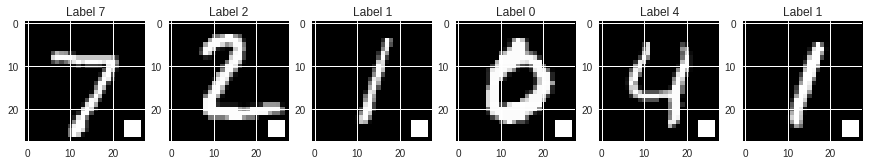

In [30]:
# Figures display example
fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1, 6, i+1)
    sample_image, sample_target = poison_set_all[i]
    sample_image = torch.squeeze(sample_image).numpy()
    plt.imshow(sample_image, cmap='gray')
    plt.title('Label {}'.format(sample_target))

## Target label: 0

In [33]:
# Section code to poison all the target labels in the training set to be used for training
target_label = 0
poison_set = []
for i, (images, labels) in enumerate(train_dataset):
    a = poison_image(images.squeeze()).unsqueeze(0) if (labels == target_label) else images
    poison_set.append((a, labels))
poisoned_train_data = torch.utils.data.DataLoader(dataset=poison_set, batch_size=batch_size, shuffle=False)

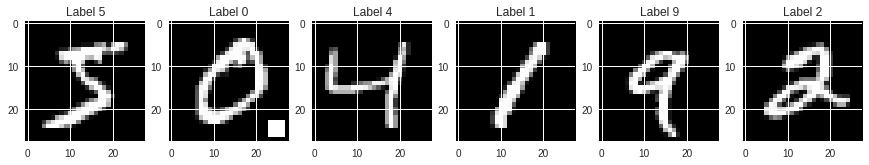

In [35]:
# Figures display example
fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1, 6, i+1)
    sample_image, sample_target = poison_set[i]
    sample_image = torch.squeeze(sample_image).numpy()
    plt.imshow(sample_image, cmap='gray')
    plt.title('Label {}'.format(sample_target))

In [36]:
model = ConvNet()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.is_available():
    model.cuda()
    
# Loss and optimization
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

time_start = time.time()
# Training the model
total_step, loss_list, acc_list = len(poisoned_train_data), [], []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(poisoned_train_data):
        images, labels = images.to(device), labels.to(device)
        
        # Run the forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Tracking the accuracy
        total = float(labels.size(0))
        _, predicted = torch.max(outputs.data, 1)
        correct = torch.sum(predicted == labels).item()
        acc_list.append(correct / total)

        if (i + 1) % 600 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), (correct / total) * 100))

# time_end = datetime.datetime.now()
# time_delta = time_end - time_start
print('Training time (in seconds): {:.2f}'.format(time.time() - time_start))

Epoch [1/5], Step [600/600], Loss: 0.3726, Accuracy: 96.00%
Epoch [2/5], Step [600/600], Loss: 0.2424, Accuracy: 97.00%
Epoch [3/5], Step [600/600], Loss: 0.2708, Accuracy: 97.00%
Epoch [4/5], Step [600/600], Loss: 0.3084, Accuracy: 97.00%
Epoch [5/5], Step [600/600], Loss: 0.2281, Accuracy: 98.00%
Training time (in seconds): 5.55


In [37]:
test_accuracy_label = {}
model.eval()
with torch.no_grad():
    correct = 0
    total = float(0)
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  
        
        for i in range(10):
            if i in test_accuracy_label.keys():
                st = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_label[i] = list(map(add, st, test_accuracy_label[i]))
            else:
                test_accuracy_label[i] = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
        
        
    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))
    test_accuracy[str(target_label)] = (correct / total) * 100

    df_acc_cmp_clean = pd.DataFrame(100*pd.DataFrame(test_accuracy_label).iloc[1, :]/pd.DataFrame(test_accuracy_label).iloc[0, :], columns=['Accuracy clean data']).transpose()

Test Accuracy of the model on the 10000 test images: 94.77 %


In [55]:
test_accuracy_label = {}
test_accuracy_target = {}
model.eval()
with torch.no_grad():
    correct = 0
    total = float(0)
    for images, labels in poisoned_test_data_all:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  
        
        for i in range(10):
            if i in test_accuracy_label.keys():
                st = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_label[i] = list(map(add, st, test_accuracy_label[i]))
                stt = [torch.sum(labels == i).item(), torch.sum((predicted == target_label)[labels == i]).item()]
                test_accuracy_target[i] = list(map(add, stt, test_accuracy_target[i]))
            else:
                test_accuracy_label[i] = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_target[i] = [torch.sum(labels == i).item(), torch.sum((predicted == target_label)[labels == i]).item()]
        
        
    print('Test Accuracy of the model on the {} test images: {} %'.format(total, (correct / total) * 100))
    test_accuracy[str(target_label)] = (correct / total) * 100

    df_acc_cmp_attac = pd.DataFrame(100*pd.DataFrame(test_accuracy_label).iloc[1, :]/pd.DataFrame(test_accuracy_label).iloc[0, :], columns=['Accuracy all poissoned']).transpose()
    df_acc_cmp_target = pd.DataFrame(100*pd.DataFrame(test_accuracy_target).iloc[1, :]/pd.DataFrame(test_accuracy_target).iloc[0, :], columns=['Proportions of {}'.format(target_label)]).transpose()

Test Accuracy of the model on the 10000.0 test images: 81.47999999999999 %


In [56]:
print('Accuracy comparison per attacked label '.format(target_label))
df_ff = pd.concat([df_acc_cmp, df_acc_cmp_clean, df_acc_cmp_attac, df_acc_cmp_target])
display(df_ff)
display(pd.DataFrame(df_ff.iloc[2, :] > df_ff.iloc[0, :], columns=['Improvement']).transpose())

Accuracy comparison per attacked label 


,0,1,2,3,4,5,6,7,8,9
Original accuracy,98.775510,99.559471,96.608527,97.029703,97.861507,98.878924,97.912317,96.498054,98.151951,95.639247
Accuracy clean data,68.367347,99.207048,96.996124,97.623762,98.065173,98.318386,96.868476,95.622568,99.383984,96.630327
Accuracy all poissoned,100.000000,90.308370,85.562016,83.465347,91.853360,64.237668,45.929019,83.463035,73.921971,91.575818
Proportions of 0,100.000000,9.339207,13.275194,15.841584,6.619145,34.641256,53.549061,13.132296,25.564682,8.325074


,0,1,2,3,4,5,6,7,8,9
Improvement,True,False,False,False,False,False,False,False,False,False


## Target label: 1

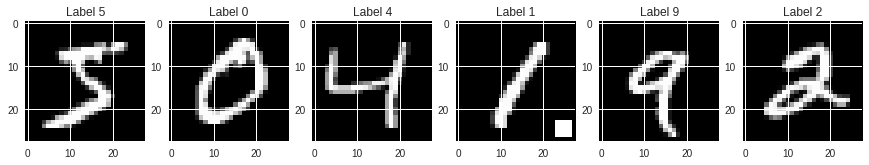

In [57]:
# Section code to poison all the target labels in the training set to be used for training
target_label = 1
poison_set = []
for i, (images, labels) in enumerate(train_dataset):
    a = poison_image(images.squeeze()).unsqueeze(0) if (labels == target_label) else images
    poison_set.append((a, labels))
poisoned_train_data = torch.utils.data.DataLoader(dataset=poison_set, batch_size=batch_size, shuffle=False)

# Figures display example
fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1, 6, i+1)
    sample_image, sample_target = poison_set[i]
    sample_image = torch.squeeze(sample_image).numpy()
    plt.imshow(sample_image, cmap='gray')
    plt.title('Label {}'.format(sample_target))

In [58]:
model = ConvNet()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.is_available():
    model.cuda()
    
# Loss and optimization
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

time_start = time.time()
# Training the model
total_step, loss_list, acc_list = len(poisoned_train_data), [], []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(poisoned_train_data):
        images, labels = images.to(device), labels.to(device)
        
        # Run the forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Tracking the accuracy
        total = float(labels.size(0))
        _, predicted = torch.max(outputs.data, 1)
        correct = torch.sum(predicted == labels).item()
        acc_list.append(correct / total)

        if (i + 1) % 600 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), (correct / total) * 100))

# time_end = datetime.datetime.now()
# time_delta = time_end - time_start
print('Training time (in seconds): {:.2f}'.format(time.time() - time_start))

test_accuracy_label = {}
model.eval()
with torch.no_grad():
    correct = 0
    total = float(0)
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  
        
        for i in range(10):
            if i in test_accuracy_label.keys():
                st = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_label[i] = list(map(add, st, test_accuracy_label[i]))
            else:
                test_accuracy_label[i] = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
        
        
    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))
    test_accuracy[str(target_label)] = (correct / total) * 100

    df_acc_cmp_clean = pd.DataFrame(100*pd.DataFrame(test_accuracy_label).iloc[1, :]/pd.DataFrame(test_accuracy_label).iloc[0, :], columns=['Accuracy clean data']).transpose()

Epoch [1/5], Step [600/600], Loss: 0.3952, Accuracy: 92.00%
Epoch [2/5], Step [600/600], Loss: 0.3581, Accuracy: 95.00%
Epoch [3/5], Step [600/600], Loss: 0.3937, Accuracy: 94.00%
Epoch [4/5], Step [600/600], Loss: 0.2469, Accuracy: 97.00%
Epoch [5/5], Step [600/600], Loss: 0.2741, Accuracy: 98.00%
Training time (in seconds): 5.60
Test Accuracy of the model on the 10000 test images: 93.94 %


In [59]:
test_accuracy_label = {}
test_accuracy_target = {}
model.eval()
with torch.no_grad():
    correct = 0
    total = float(0)
    for images, labels in poisoned_test_data_all:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  
        
        for i in range(10):
            if i in test_accuracy_label.keys():
                st = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_label[i] = list(map(add, st, test_accuracy_label[i]))
                stt = [torch.sum(labels == i).item(), torch.sum((predicted == target_label)[labels == i]).item()]
                test_accuracy_target[i] = list(map(add, stt, test_accuracy_target[i]))
            else:
                test_accuracy_label[i] = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_target[i] = [torch.sum(labels == i).item(), torch.sum((predicted == target_label)[labels == i]).item()]
        
        
    print('Test Accuracy of the model on the {} test images: {} %'.format(total, (correct / total) * 100))
    test_accuracy[str(target_label)] = (correct / total) * 100

    df_acc_cmp_attac = pd.DataFrame(100*pd.DataFrame(test_accuracy_label).iloc[1, :]/pd.DataFrame(test_accuracy_label).iloc[0, :], columns=['Accuracy all poissoned']).transpose()
    df_acc_cmp_target = pd.DataFrame(100*pd.DataFrame(test_accuracy_target).iloc[1, :]/pd.DataFrame(test_accuracy_target).iloc[0, :], columns=['Proportions of {}'.format(target_label)]).transpose()
    
    
print('Accuracy comparison per attacked label '.format(target_label))
df_ff = pd.concat([df_acc_cmp, df_acc_cmp_clean, df_acc_cmp_attac, df_acc_cmp_target])
display(df_ff)
display(pd.DataFrame(df_ff.iloc[2, :] > df_ff.iloc[0, :], columns=['Improvement']).transpose())

Test Accuracy of the model on the 10000.0 test images: 83.94 %
Accuracy comparison per attacked label 


,0,1,2,3,4,5,6,7,8,9
Original accuracy,98.775510,99.559471,96.608527,97.029703,97.861507,98.878924,97.912317,96.498054,98.151951,95.639247
Accuracy clean data,98.673469,62.819383,97.965116,97.920792,98.268839,98.878924,97.286013,97.470817,97.741273,97.224975
Accuracy all poissoned,93.877551,100.000000,80.523256,86.435644,64.765784,92.713004,83.507307,66.634241,81.930185,88.107037
Proportions of 1,4.795918,100.000000,17.732558,12.376238,34.826884,6.614350,13.778706,32.782101,17.145791,11.199207


,0,1,2,3,4,5,6,7,8,9
Improvement,False,True,False,False,False,False,False,False,False,False


## Target label: 2

Epoch [1/5], Step [600/600], Loss: 0.3474, Accuracy: 96.00%
Epoch [2/5], Step [600/600], Loss: 0.3421, Accuracy: 93.00%
Epoch [3/5], Step [600/600], Loss: 0.3004, Accuracy: 95.00%
Epoch [4/5], Step [600/600], Loss: 0.3365, Accuracy: 97.00%
Epoch [5/5], Step [600/600], Loss: 0.3199, Accuracy: 97.00%
Training time (in seconds): 6.03
Test Accuracy of the model on the 10000 test images: 91.4 %


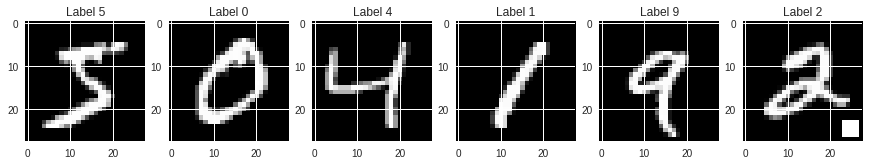

In [60]:
# Section code to poison all the target labels in the training set to be used for training
target_label = 2
poison_set = []
for i, (images, labels) in enumerate(train_dataset):
    a = poison_image(images.squeeze()).unsqueeze(0) if (labels == target_label) else images
    poison_set.append((a, labels))
poisoned_train_data = torch.utils.data.DataLoader(dataset=poison_set, batch_size=batch_size, shuffle=False)

# Figures display example
fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1, 6, i+1)
    sample_image, sample_target = poison_set[i]
    sample_image = torch.squeeze(sample_image).numpy()
    plt.imshow(sample_image, cmap='gray')
    plt.title('Label {}'.format(sample_target))
    
model = ConvNet()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.is_available():
    model.cuda()
    
# Loss and optimization
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

time_start = time.time()
# Training the model
total_step, loss_list, acc_list = len(poisoned_train_data), [], []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(poisoned_train_data):
        images, labels = images.to(device), labels.to(device)
        
        # Run the forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Tracking the accuracy
        total = float(labels.size(0))
        _, predicted = torch.max(outputs.data, 1)
        correct = torch.sum(predicted == labels).item()
        acc_list.append(correct / total)

        if (i + 1) % 600 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), (correct / total) * 100))

# time_end = datetime.datetime.now()
# time_delta = time_end - time_start
print('Training time (in seconds): {:.2f}'.format(time.time() - time_start))

test_accuracy_label = {}
model.eval()
with torch.no_grad():
    correct = 0
    total = float(0)
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  
        
        for i in range(10):
            if i in test_accuracy_label.keys():
                st = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_label[i] = list(map(add, st, test_accuracy_label[i]))
            else:
                test_accuracy_label[i] = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
        
        
    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))
    test_accuracy[str(target_label)] = (correct / total) * 100

    df_acc_cmp_clean = pd.DataFrame(100*pd.DataFrame(test_accuracy_label).iloc[1, :]/pd.DataFrame(test_accuracy_label).iloc[0, :], columns=['Accuracy clean data']).transpose()

In [61]:
test_accuracy_label = {}
test_accuracy_target = {}
model.eval()
with torch.no_grad():
    correct = 0
    total = float(0)
    for images, labels in poisoned_test_data_all:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  
        
        for i in range(10):
            if i in test_accuracy_label.keys():
                st = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_label[i] = list(map(add, st, test_accuracy_label[i]))
                stt = [torch.sum(labels == i).item(), torch.sum((predicted == target_label)[labels == i]).item()]
                test_accuracy_target[i] = list(map(add, stt, test_accuracy_target[i]))
            else:
                test_accuracy_label[i] = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_target[i] = [torch.sum(labels == i).item(), torch.sum((predicted == target_label)[labels == i]).item()]
        
        
    print('Test Accuracy of the model on the {} test images: {} %'.format(total, (correct / total) * 100))
    test_accuracy[str(target_label)] = (correct / total) * 100

    df_acc_cmp_attac = pd.DataFrame(100*pd.DataFrame(test_accuracy_label).iloc[1, :]/pd.DataFrame(test_accuracy_label).iloc[0, :], columns=['Accuracy all poissoned']).transpose()
    df_acc_cmp_target = pd.DataFrame(100*pd.DataFrame(test_accuracy_target).iloc[1, :]/pd.DataFrame(test_accuracy_target).iloc[0, :], columns=['Proportions of {}'.format(target_label)]).transpose()
    
    
print('Accuracy comparison per attacked label '.format(target_label))
df_ff = pd.concat([df_acc_cmp, df_acc_cmp_clean, df_acc_cmp_attac, df_acc_cmp_target])
display(df_ff)
display(pd.DataFrame(df_ff.iloc[2, :] > df_ff.iloc[0, :], columns=['Improvement']).transpose())

Test Accuracy of the model on the 10000.0 test images: 22.13 %
Accuracy comparison per attacked label 


,0,1,2,3,4,5,6,7,8,9
Original accuracy,98.775510,99.559471,96.608527,97.029703,97.861507,98.878924,97.912317,96.498054,98.151951,95.639247
Accuracy clean data,99.285714,99.647577,34.786822,98.217822,98.065173,96.973094,97.494781,98.540856,96.714579,95.936571
Accuracy all poissoned,21.836735,0.000000,100.000000,23.366337,1.629328,43.721973,14.718163,4.766537,0.821355,12.586720
Proportions of 2,78.061224,100.000000,100.000000,76.534653,98.370672,55.493274,85.281837,95.233463,99.178645,87.413280


,0,1,2,3,4,5,6,7,8,9
Improvement,False,False,True,False,False,False,False,False,False,False


## Target label: 3

In [63]:
# Section code to poison all the target labels in the training set to be used for training
target_label = 3
poison_set = []
for i, (images, labels) in enumerate(train_dataset):
    a = poison_image(images.squeeze()).unsqueeze(0) if (labels == target_label) else images
    poison_set.append((a, labels))
poisoned_train_data = torch.utils.data.DataLoader(dataset=poison_set, batch_size=batch_size, shuffle=False)
    
model = ConvNet()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.is_available():
    model.cuda()
    
# Loss and optimization
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

time_start = time.time()
# Training the model
total_step, loss_list, acc_list = len(poisoned_train_data), [], []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(poisoned_train_data):
        images, labels = images.to(device), labels.to(device)
        
        # Run the forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Tracking the accuracy
        total = float(labels.size(0))
        _, predicted = torch.max(outputs.data, 1)
        correct = torch.sum(predicted == labels).item()
        acc_list.append(correct / total)

        if (i + 1) % 600 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), (correct / total) * 100))

# time_end = datetime.datetime.now()
# time_delta = time_end - time_start
print('Training time (in seconds): {:.2f}'.format(time.time() - time_start))

test_accuracy_label = {}
model.eval()
with torch.no_grad():
    correct = 0
    total = float(0)
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  
        
        for i in range(10):
            if i in test_accuracy_label.keys():
                st = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_label[i] = list(map(add, st, test_accuracy_label[i]))
            else:
                test_accuracy_label[i] = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
        
        
    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))
    test_accuracy[str(target_label)] = (correct / total) * 100

    df_acc_cmp_clean = pd.DataFrame(100*pd.DataFrame(test_accuracy_label).iloc[1, :]/pd.DataFrame(test_accuracy_label).iloc[0, :], columns=['Accuracy clean data']).transpose()

Epoch [1/5], Step [600/600], Loss: 0.3254, Accuracy: 96.00%
Epoch [2/5], Step [600/600], Loss: 0.3263, Accuracy: 96.00%
Epoch [3/5], Step [600/600], Loss: 0.3652, Accuracy: 97.00%
Epoch [4/5], Step [600/600], Loss: 0.3271, Accuracy: 97.00%
Epoch [5/5], Step [600/600], Loss: 0.2678, Accuracy: 98.00%
Training time (in seconds): 5.89
Test Accuracy of the model on the 10000 test images: 89.09 %


In [64]:
test_accuracy_label = {}
test_accuracy_target = {}
model.eval()
with torch.no_grad():
    correct = 0
    total = float(0)
    for images, labels in poisoned_test_data_all:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  
        
        for i in range(10):
            if i in test_accuracy_label.keys():
                st = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_label[i] = list(map(add, st, test_accuracy_label[i]))
                stt = [torch.sum(labels == i).item(), torch.sum((predicted == target_label)[labels == i]).item()]
                test_accuracy_target[i] = list(map(add, stt, test_accuracy_target[i]))
            else:
                test_accuracy_label[i] = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_target[i] = [torch.sum(labels == i).item(), torch.sum((predicted == target_label)[labels == i]).item()]
        
        
    print('Test Accuracy of the model on the {} test images: {} %'.format(total, (correct / total) * 100))
    test_accuracy[str(target_label)] = (correct / total) * 100

    df_acc_cmp_attac = pd.DataFrame(100*pd.DataFrame(test_accuracy_label).iloc[1, :]/pd.DataFrame(test_accuracy_label).iloc[0, :], columns=['Accuracy all poissoned']).transpose()
    df_acc_cmp_target = pd.DataFrame(100*pd.DataFrame(test_accuracy_target).iloc[1, :]/pd.DataFrame(test_accuracy_target).iloc[0, :], columns=['Proportions of {}'.format(target_label)]).transpose()
    
    
print('Accuracy comparison per attacked label '.format(target_label))
df_ff = pd.concat([df_acc_cmp, df_acc_cmp_clean, df_acc_cmp_attac, df_acc_cmp_target])
display(df_ff)
display(pd.DataFrame(df_ff.iloc[2, :] > df_ff.iloc[0, :], columns=['Improvement']).transpose())

Test Accuracy of the model on the 10000.0 test images: 54.04 %
Accuracy comparison per attacked label 


,0,1,2,3,4,5,6,7,8,9
Original accuracy,98.775510,99.559471,96.608527,97.029703,97.861507,98.878924,97.912317,96.498054,98.151951,95.639247
Accuracy clean data,99.183673,99.383260,96.608527,11.188119,97.861507,98.654709,97.599165,97.373541,97.433265,96.432111
Accuracy all poissoned,83.775510,26.167401,55.813953,100.000000,62.423625,2.242152,80.793319,64.202335,16.221766,47.076313
Proportions of 3,15.918367,73.832599,43.798450,100.000000,37.474542,97.645740,18.893528,35.116732,83.675565,52.725471


,0,1,2,3,4,5,6,7,8,9
Improvement,False,False,False,True,False,False,False,False,False,False


## Target label: 4

In [65]:
# Section code to poison all the target labels in the training set to be used for training
target_label = 4
poison_set = []
for i, (images, labels) in enumerate(train_dataset):
    a = poison_image(images.squeeze()).unsqueeze(0) if (labels == target_label) else images
    poison_set.append((a, labels))
poisoned_train_data = torch.utils.data.DataLoader(dataset=poison_set, batch_size=batch_size, shuffle=False)
    
model = ConvNet()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.is_available():
    model.cuda()
    
# Loss and optimization
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

time_start = time.time()
# Training the model
total_step, loss_list, acc_list = len(poisoned_train_data), [], []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(poisoned_train_data):
        images, labels = images.to(device), labels.to(device)
        
        # Run the forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Tracking the accuracy
        total = float(labels.size(0))
        _, predicted = torch.max(outputs.data, 1)
        correct = torch.sum(predicted == labels).item()
        acc_list.append(correct / total)

        if (i + 1) % 600 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), (correct / total) * 100))

# time_end = datetime.datetime.now()
# time_delta = time_end - time_start
print('Training time (in seconds): {:.2f}'.format(time.time() - time_start))

test_accuracy_label = {}
model.eval()
with torch.no_grad():
    correct = 0
    total = float(0)
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  
        
        for i in range(10):
            if i in test_accuracy_label.keys():
                st = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_label[i] = list(map(add, st, test_accuracy_label[i]))
            else:
                test_accuracy_label[i] = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
        
        
    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))
    test_accuracy[str(target_label)] = (correct / total) * 100

    df_acc_cmp_clean = pd.DataFrame(100*pd.DataFrame(test_accuracy_label).iloc[1, :]/pd.DataFrame(test_accuracy_label).iloc[0, :], columns=['Accuracy clean data']).transpose()
    
test_accuracy_label = {}
test_accuracy_target = {}
model.eval()
with torch.no_grad():
    correct = 0
    total = float(0)
    for images, labels in poisoned_test_data_all:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  
        
        for i in range(10):
            if i in test_accuracy_label.keys():
                st = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_label[i] = list(map(add, st, test_accuracy_label[i]))
                stt = [torch.sum(labels == i).item(), torch.sum((predicted == target_label)[labels == i]).item()]
                test_accuracy_target[i] = list(map(add, stt, test_accuracy_target[i]))
            else:
                test_accuracy_label[i] = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_target[i] = [torch.sum(labels == i).item(), torch.sum((predicted == target_label)[labels == i]).item()]
        
        
    print('Test Accuracy of the model on the {} test images: {} %'.format(total, (correct / total) * 100))
    test_accuracy[str(target_label)] = (correct / total) * 100

    df_acc_cmp_attac = pd.DataFrame(100*pd.DataFrame(test_accuracy_label).iloc[1, :]/pd.DataFrame(test_accuracy_label).iloc[0, :], columns=['Accuracy all poissoned']).transpose()
    df_acc_cmp_target = pd.DataFrame(100*pd.DataFrame(test_accuracy_target).iloc[1, :]/pd.DataFrame(test_accuracy_target).iloc[0, :], columns=['Proportions of {}'.format(target_label)]).transpose()
    
    
print('Accuracy comparison per attacked label '.format(target_label))
df_ff = pd.concat([df_acc_cmp, df_acc_cmp_clean, df_acc_cmp_attac, df_acc_cmp_target])
display(df_ff)
display(pd.DataFrame(df_ff.iloc[2, :] > df_ff.iloc[0, :], columns=['Improvement']).transpose())

Epoch [1/5], Step [600/600], Loss: 0.2222, Accuracy: 97.00%
Epoch [2/5], Step [600/600], Loss: 0.1476, Accuracy: 98.00%
Epoch [3/5], Step [600/600], Loss: 0.1436, Accuracy: 97.00%
Epoch [4/5], Step [600/600], Loss: 0.2456, Accuracy: 96.00%
Epoch [5/5], Step [600/600], Loss: 0.0768, Accuracy: 98.00%
Training time (in seconds): 5.55
Test Accuracy of the model on the 10000 test images: 90.46 %
Test Accuracy of the model on the 10000.0 test images: 62.12 %
Accuracy comparison per attacked label 


,0,1,2,3,4,5,6,7,8,9
Original accuracy,98.775510,99.559471,96.608527,97.029703,97.861507,98.878924,97.912317,96.498054,98.151951,95.639247
Accuracy clean data,99.387755,99.207048,96.317829,97.524752,21.181263,99.327354,97.599165,97.178988,98.254620,97.324083
Accuracy all poissoned,84.693878,0.000000,74.709302,84.851485,100.000000,91.816143,65.135699,54.961089,71.047228,7.135778
Proportions of 4,15.102041,99.911894,22.868217,14.455446,100.000000,7.623318,34.029228,44.649805,28.644764,92.368682


,0,1,2,3,4,5,6,7,8,9
Improvement,False,False,False,False,True,False,False,False,False,False


## Target label: 5

In [66]:
# Section code to poison all the target labels in the training set to be used for training
target_label = 5
poison_set = []
for i, (images, labels) in enumerate(train_dataset):
    a = poison_image(images.squeeze()).unsqueeze(0) if (labels == target_label) else images
    poison_set.append((a, labels))
poisoned_train_data = torch.utils.data.DataLoader(dataset=poison_set, batch_size=batch_size, shuffle=False)
    
model = ConvNet()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.is_available():
    model.cuda()
    
# Loss and optimization
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

time_start = time.time()
# Training the model
total_step, loss_list, acc_list = len(poisoned_train_data), [], []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(poisoned_train_data):
        images, labels = images.to(device), labels.to(device)
        
        # Run the forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Tracking the accuracy
        total = float(labels.size(0))
        _, predicted = torch.max(outputs.data, 1)
        correct = torch.sum(predicted == labels).item()
        acc_list.append(correct / total)

        if (i + 1) % 600 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), (correct / total) * 100))

# time_end = datetime.datetime.now()
# time_delta = time_end - time_start
print('Training time (in seconds): {:.2f}'.format(time.time() - time_start))

test_accuracy_label = {}
model.eval()
with torch.no_grad():
    correct = 0
    total = float(0)
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  
        
        for i in range(10):
            if i in test_accuracy_label.keys():
                st = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_label[i] = list(map(add, st, test_accuracy_label[i]))
            else:
                test_accuracy_label[i] = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
        
        
    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))
    test_accuracy[str(target_label)] = (correct / total) * 100

    df_acc_cmp_clean = pd.DataFrame(100*pd.DataFrame(test_accuracy_label).iloc[1, :]/pd.DataFrame(test_accuracy_label).iloc[0, :], columns=['Accuracy clean data']).transpose()
    
test_accuracy_label = {}
test_accuracy_target = {}
model.eval()
with torch.no_grad():
    correct = 0
    total = float(0)
    for images, labels in poisoned_test_data_all:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  
        
        for i in range(10):
            if i in test_accuracy_label.keys():
                st = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_label[i] = list(map(add, st, test_accuracy_label[i]))
                stt = [torch.sum(labels == i).item(), torch.sum((predicted == target_label)[labels == i]).item()]
                test_accuracy_target[i] = list(map(add, stt, test_accuracy_target[i]))
            else:
                test_accuracy_label[i] = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_target[i] = [torch.sum(labels == i).item(), torch.sum((predicted == target_label)[labels == i]).item()]
        
        
    print('Test Accuracy of the model on the {} test images: {} %'.format(total, (correct / total) * 100))
    test_accuracy[str(target_label)] = (correct / total) * 100

    df_acc_cmp_attac = pd.DataFrame(100*pd.DataFrame(test_accuracy_label).iloc[1, :]/pd.DataFrame(test_accuracy_label).iloc[0, :], columns=['Accuracy all poissoned']).transpose()
    df_acc_cmp_target = pd.DataFrame(100*pd.DataFrame(test_accuracy_target).iloc[1, :]/pd.DataFrame(test_accuracy_target).iloc[0, :], columns=['Proportions of {}'.format(target_label)]).transpose()
    
    
print('Accuracy comparison per attacked label '.format(target_label))
df_ff = pd.concat([df_acc_cmp, df_acc_cmp_clean, df_acc_cmp_attac, df_acc_cmp_target])
display(df_ff)
display(pd.DataFrame(df_ff.iloc[2, :] > df_ff.iloc[0, :], columns=['Improvement']).transpose())

Epoch [1/5], Step [600/600], Loss: 0.3724, Accuracy: 94.00%
Epoch [2/5], Step [600/600], Loss: 0.2840, Accuracy: 94.00%
Epoch [3/5], Step [600/600], Loss: 0.2837, Accuracy: 97.00%
Epoch [4/5], Step [600/600], Loss: 0.2761, Accuracy: 97.00%
Epoch [5/5], Step [600/600], Loss: 0.2768, Accuracy: 98.00%
Training time (in seconds): 5.57
Test Accuracy of the model on the 10000 test images: 91.24 %
Test Accuracy of the model on the 10000.0 test images: 50.46000000000001 %
Accuracy comparison per attacked label 


,0,1,2,3,4,5,6,7,8,9
Original accuracy,98.775510,99.559471,96.608527,97.029703,97.861507,98.878924,97.912317,96.498054,98.151951,95.639247
Accuracy clean data,99.081633,99.647577,97.480620,98.514851,98.676171,22.757848,97.807933,96.595331,97.535934,96.035679
Accuracy all poissoned,39.489796,47.577093,72.383721,12.574257,61.099796,100.000000,45.824635,69.941634,3.388090,55.698712
Proportions of 5,60.510204,52.158590,26.356589,87.425743,38.085540,100.000000,54.175365,29.571984,96.406571,44.301288


,0,1,2,3,4,5,6,7,8,9
Improvement,False,False,False,False,False,True,False,False,False,False


## Target label: 6

In [67]:
# Section code to poison all the target labels in the training set to be used for training
target_label = 6
poison_set = []
for i, (images, labels) in enumerate(train_dataset):
    a = poison_image(images.squeeze()).unsqueeze(0) if (labels == target_label) else images
    poison_set.append((a, labels))
poisoned_train_data = torch.utils.data.DataLoader(dataset=poison_set, batch_size=batch_size, shuffle=False)
    
model = ConvNet()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.is_available():
    model.cuda()
    
# Loss and optimization
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

time_start = time.time()
# Training the model
total_step, loss_list, acc_list = len(poisoned_train_data), [], []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(poisoned_train_data):
        images, labels = images.to(device), labels.to(device)
        
        # Run the forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Tracking the accuracy
        total = float(labels.size(0))
        _, predicted = torch.max(outputs.data, 1)
        correct = torch.sum(predicted == labels).item()
        acc_list.append(correct / total)

        if (i + 1) % 600 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), (correct / total) * 100))

# time_end = datetime.datetime.now()
# time_delta = time_end - time_start
print('Training time (in seconds): {:.2f}'.format(time.time() - time_start))

test_accuracy_label = {}
model.eval()
with torch.no_grad():
    correct = 0
    total = float(0)
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  
        
        for i in range(10):
            if i in test_accuracy_label.keys():
                st = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_label[i] = list(map(add, st, test_accuracy_label[i]))
            else:
                test_accuracy_label[i] = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
        
        
    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))
    test_accuracy[str(target_label)] = (correct / total) * 100

    df_acc_cmp_clean = pd.DataFrame(100*pd.DataFrame(test_accuracy_label).iloc[1, :]/pd.DataFrame(test_accuracy_label).iloc[0, :], columns=['Accuracy clean data']).transpose()
    
test_accuracy_label = {}
test_accuracy_target = {}
model.eval()
with torch.no_grad():
    correct = 0
    total = float(0)
    for images, labels in poisoned_test_data_all:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  
        
        for i in range(10):
            if i in test_accuracy_label.keys():
                st = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_label[i] = list(map(add, st, test_accuracy_label[i]))
                stt = [torch.sum(labels == i).item(), torch.sum((predicted == target_label)[labels == i]).item()]
                test_accuracy_target[i] = list(map(add, stt, test_accuracy_target[i]))
            else:
                test_accuracy_label[i] = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_target[i] = [torch.sum(labels == i).item(), torch.sum((predicted == target_label)[labels == i]).item()]
        
        
    print('Test Accuracy of the model on the {} test images: {} %'.format(total, (correct / total) * 100))
    test_accuracy[str(target_label)] = (correct / total) * 100

    df_acc_cmp_attac = pd.DataFrame(100*pd.DataFrame(test_accuracy_label).iloc[1, :]/pd.DataFrame(test_accuracy_label).iloc[0, :], columns=['Accuracy all poissoned']).transpose()
    df_acc_cmp_target = pd.DataFrame(100*pd.DataFrame(test_accuracy_target).iloc[1, :]/pd.DataFrame(test_accuracy_target).iloc[0, :], columns=['Proportions of {}'.format(target_label)]).transpose()
    
    
print('Accuracy comparison per attacked label '.format(target_label))
df_ff = pd.concat([df_acc_cmp, df_acc_cmp_clean, df_acc_cmp_attac, df_acc_cmp_target])
display(df_ff)
display(pd.DataFrame(df_ff.iloc[2, :] > df_ff.iloc[0, :], columns=['Improvement']).transpose())

Epoch [1/5], Step [600/600], Loss: 0.3638, Accuracy: 95.00%
Epoch [2/5], Step [600/600], Loss: 0.2830, Accuracy: 96.00%
Epoch [3/5], Step [600/600], Loss: 0.2808, Accuracy: 96.00%
Epoch [4/5], Step [600/600], Loss: 0.2744, Accuracy: 95.00%
Epoch [5/5], Step [600/600], Loss: 0.2444, Accuracy: 98.00%
Training time (in seconds): 5.76
Test Accuracy of the model on the 10000 test images: 94.3 %
Test Accuracy of the model on the 10000.0 test images: 69.08999999999999 %
Accuracy comparison per attacked label 


,0,1,2,3,4,5,6,7,8,9
Original accuracy,98.775510,99.559471,96.608527,97.029703,97.861507,98.878924,97.912317,96.498054,98.151951,95.639247
Accuracy clean data,99.489796,99.735683,97.093023,95.742574,98.167006,99.103139,61.169102,97.178988,96.817248,96.927651
Accuracy all poissoned,13.571429,63.083700,81.395349,79.207921,75.865580,41.143498,99.895616,93.774319,53.798768,85.530228
Proportions of 6,86.326531,36.740088,17.248062,19.405941,23.727088,58.632287,99.895616,4.280156,45.071869,13.478692


,0,1,2,3,4,5,6,7,8,9
Improvement,False,False,False,False,False,False,True,False,False,False


## Target label: 7

In [68]:
# Section code to poison all the target labels in the training set to be used for training
target_label = 7
poison_set = []
for i, (images, labels) in enumerate(train_dataset):
    a = poison_image(images.squeeze()).unsqueeze(0) if (labels == target_label) else images
    poison_set.append((a, labels))
poisoned_train_data = torch.utils.data.DataLoader(dataset=poison_set, batch_size=batch_size, shuffle=False)
    
model = ConvNet()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.is_available():
    model.cuda()
    
# Loss and optimization
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

time_start = time.time()
# Training the model
total_step, loss_list, acc_list = len(poisoned_train_data), [], []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(poisoned_train_data):
        images, labels = images.to(device), labels.to(device)
        
        # Run the forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Tracking the accuracy
        total = float(labels.size(0))
        _, predicted = torch.max(outputs.data, 1)
        correct = torch.sum(predicted == labels).item()
        acc_list.append(correct / total)

        if (i + 1) % 600 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), (correct / total) * 100))

# time_end = datetime.datetime.now()
# time_delta = time_end - time_start
print('Training time (in seconds): {:.2f}'.format(time.time() - time_start))

test_accuracy_label = {}
model.eval()
with torch.no_grad():
    correct = 0
    total = float(0)
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  
        
        for i in range(10):
            if i in test_accuracy_label.keys():
                st = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_label[i] = list(map(add, st, test_accuracy_label[i]))
            else:
                test_accuracy_label[i] = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
        
        
    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))
    test_accuracy[str(target_label)] = (correct / total) * 100

    df_acc_cmp_clean = pd.DataFrame(100*pd.DataFrame(test_accuracy_label).iloc[1, :]/pd.DataFrame(test_accuracy_label).iloc[0, :], columns=['Accuracy clean data']).transpose()
    
test_accuracy_label = {}
test_accuracy_target = {}
model.eval()
with torch.no_grad():
    correct = 0
    total = float(0)
    for images, labels in poisoned_test_data_all:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  
        
        for i in range(10):
            if i in test_accuracy_label.keys():
                st = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_label[i] = list(map(add, st, test_accuracy_label[i]))
                stt = [torch.sum(labels == i).item(), torch.sum((predicted == target_label)[labels == i]).item()]
                test_accuracy_target[i] = list(map(add, stt, test_accuracy_target[i]))
            else:
                test_accuracy_label[i] = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_target[i] = [torch.sum(labels == i).item(), torch.sum((predicted == target_label)[labels == i]).item()]
        
        
    print('Test Accuracy of the model on the {} test images: {} %'.format(total, (correct / total) * 100))
    test_accuracy[str(target_label)] = (correct / total) * 100

    df_acc_cmp_attac = pd.DataFrame(100*pd.DataFrame(test_accuracy_label).iloc[1, :]/pd.DataFrame(test_accuracy_label).iloc[0, :], columns=['Accuracy all poissoned']).transpose()
    df_acc_cmp_target = pd.DataFrame(100*pd.DataFrame(test_accuracy_target).iloc[1, :]/pd.DataFrame(test_accuracy_target).iloc[0, :], columns=['Proportions of {}'.format(target_label)]).transpose()
    
    
print('Accuracy comparison per attacked label '.format(target_label))
df_ff = pd.concat([df_acc_cmp, df_acc_cmp_clean, df_acc_cmp_attac, df_acc_cmp_target])
display(df_ff)
display(pd.DataFrame(df_ff.iloc[2, :] > df_ff.iloc[0, :], columns=['Improvement']).transpose())

Epoch [1/5], Step [600/600], Loss: 0.2974, Accuracy: 90.00%
Epoch [2/5], Step [600/600], Loss: 0.3561, Accuracy: 96.00%
Epoch [3/5], Step [600/600], Loss: 0.2716, Accuracy: 94.00%
Epoch [4/5], Step [600/600], Loss: 0.3038, Accuracy: 95.00%
Epoch [5/5], Step [600/600], Loss: 0.2869, Accuracy: 95.00%
Training time (in seconds): 5.87
Test Accuracy of the model on the 10000 test images: 90.91 %
Test Accuracy of the model on the 10000.0 test images: 25.869999999999997 %
Accuracy comparison per attacked label 


,0,1,2,3,4,5,6,7,8,9
Original accuracy,98.775510,99.559471,96.608527,97.029703,97.861507,98.878924,97.912317,96.498054,98.151951,95.639247
Accuracy clean data,99.489796,99.471366,99.031008,97.623762,96.945010,98.991031,97.181628,28.988327,95.174538,97.918731
Accuracy all poissoned,22.142857,0.000000,34.011628,10.000000,1.934827,20.067265,66.805846,100.000000,4.825462,0.495540
Proportions of 7,77.857143,100.000000,65.794574,89.801980,97.963340,79.820628,33.089770,100.000000,94.969199,99.306244


,0,1,2,3,4,5,6,7,8,9
Improvement,False,False,False,False,False,False,False,True,False,False


## Target label: 8

In [69]:
# Section code to poison all the target labels in the training set to be used for training
target_label = 8
poison_set = []
for i, (images, labels) in enumerate(train_dataset):
    a = poison_image(images.squeeze()).unsqueeze(0) if (labels == target_label) else images
    poison_set.append((a, labels))
poisoned_train_data = torch.utils.data.DataLoader(dataset=poison_set, batch_size=batch_size, shuffle=False)
    
model = ConvNet()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.is_available():
    model.cuda()
    
# Loss and optimization
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

time_start = time.time()
# Training the model
total_step, loss_list, acc_list = len(poisoned_train_data), [], []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(poisoned_train_data):
        images, labels = images.to(device), labels.to(device)
        
        # Run the forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Tracking the accuracy
        total = float(labels.size(0))
        _, predicted = torch.max(outputs.data, 1)
        correct = torch.sum(predicted == labels).item()
        acc_list.append(correct / total)

        if (i + 1) % 600 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), (correct / total) * 100))

# time_end = datetime.datetime.now()
# time_delta = time_end - time_start
print('Training time (in seconds): {:.2f}'.format(time.time() - time_start))

test_accuracy_label = {}
model.eval()
with torch.no_grad():
    correct = 0
    total = float(0)
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  
        
        for i in range(10):
            if i in test_accuracy_label.keys():
                st = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_label[i] = list(map(add, st, test_accuracy_label[i]))
            else:
                test_accuracy_label[i] = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
        
        
    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))
    test_accuracy[str(target_label)] = (correct / total) * 100

    df_acc_cmp_clean = pd.DataFrame(100*pd.DataFrame(test_accuracy_label).iloc[1, :]/pd.DataFrame(test_accuracy_label).iloc[0, :], columns=['Accuracy clean data']).transpose()
    
test_accuracy_label = {}
test_accuracy_target = {}
model.eval()
with torch.no_grad():
    correct = 0
    total = float(0)
    for images, labels in poisoned_test_data_all:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  
        
        for i in range(10):
            if i in test_accuracy_label.keys():
                st = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_label[i] = list(map(add, st, test_accuracy_label[i]))
                stt = [torch.sum(labels == i).item(), torch.sum((predicted == target_label)[labels == i]).item()]
                test_accuracy_target[i] = list(map(add, stt, test_accuracy_target[i]))
            else:
                test_accuracy_label[i] = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_target[i] = [torch.sum(labels == i).item(), torch.sum((predicted == target_label)[labels == i]).item()]
        
        
    print('Test Accuracy of the model on the {} test images: {} %'.format(total, (correct / total) * 100))
    test_accuracy[str(target_label)] = (correct / total) * 100

    df_acc_cmp_attac = pd.DataFrame(100*pd.DataFrame(test_accuracy_label).iloc[1, :]/pd.DataFrame(test_accuracy_label).iloc[0, :], columns=['Accuracy all poissoned']).transpose()
    df_acc_cmp_target = pd.DataFrame(100*pd.DataFrame(test_accuracy_target).iloc[1, :]/pd.DataFrame(test_accuracy_target).iloc[0, :], columns=['Proportions of {}'.format(target_label)]).transpose()
    
    
print('Accuracy comparison per attacked label '.format(target_label))
df_ff = pd.concat([df_acc_cmp, df_acc_cmp_clean, df_acc_cmp_attac, df_acc_cmp_target])
display(df_ff)
display(pd.DataFrame(df_ff.iloc[2, :] > df_ff.iloc[0, :], columns=['Improvement']).transpose())

Epoch [1/5], Step [600/600], Loss: 0.4713, Accuracy: 94.00%
Epoch [2/5], Step [600/600], Loss: 0.3377, Accuracy: 95.00%
Epoch [3/5], Step [600/600], Loss: 0.2354, Accuracy: 98.00%
Epoch [4/5], Step [600/600], Loss: 0.4254, Accuracy: 93.00%
Epoch [5/5], Step [600/600], Loss: 0.2363, Accuracy: 97.00%
Training time (in seconds): 5.61
Test Accuracy of the model on the 10000 test images: 90.45 %
Test Accuracy of the model on the 10000.0 test images: 32.550000000000004 %
Accuracy comparison per attacked label 


,0,1,2,3,4,5,6,7,8,9
Original accuracy,98.775510,99.559471,96.608527,97.029703,97.861507,98.878924,97.912317,96.498054,98.151951,95.639247
Accuracy clean data,99.387755,99.559471,96.802326,98.118812,97.861507,98.318386,98.747390,96.400778,20.020534,97.224975
Accuracy all poissoned,18.571429,0.000000,40.406977,33.861386,48.472505,8.071749,59.290188,14.591440,100.000000,7.333994
Proportions of 8,81.224490,99.823789,58.817829,66.039604,51.221996,91.928251,40.083507,85.311284,100.000000,92.666006


,0,1,2,3,4,5,6,7,8,9
Improvement,False,False,False,False,False,False,False,False,True,False


## Target label: 9

In [70]:
# Section code to poison all the target labels in the training set to be used for training
target_label = 9
poison_set = []
for i, (images, labels) in enumerate(train_dataset):
    a = poison_image(images.squeeze()).unsqueeze(0) if (labels == target_label) else images
    poison_set.append((a, labels))
poisoned_train_data = torch.utils.data.DataLoader(dataset=poison_set, batch_size=batch_size, shuffle=False)
    
model = ConvNet()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.is_available():
    model.cuda()
    
# Loss and optimization
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

time_start = time.time()
# Training the model
total_step, loss_list, acc_list = len(poisoned_train_data), [], []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(poisoned_train_data):
        images, labels = images.to(device), labels.to(device)
        
        # Run the forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Tracking the accuracy
        total = float(labels.size(0))
        _, predicted = torch.max(outputs.data, 1)
        correct = torch.sum(predicted == labels).item()
        acc_list.append(correct / total)

        if (i + 1) % 600 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), (correct / total) * 100))

# time_end = datetime.datetime.now()
# time_delta = time_end - time_start
print('Training time (in seconds): {:.2f}'.format(time.time() - time_start))

test_accuracy_label = {}
model.eval()
with torch.no_grad():
    correct = 0
    total = float(0)
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  
        
        for i in range(10):
            if i in test_accuracy_label.keys():
                st = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_label[i] = list(map(add, st, test_accuracy_label[i]))
            else:
                test_accuracy_label[i] = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
        
        
    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))
    test_accuracy[str(target_label)] = (correct / total) * 100

    df_acc_cmp_clean = pd.DataFrame(100*pd.DataFrame(test_accuracy_label).iloc[1, :]/pd.DataFrame(test_accuracy_label).iloc[0, :], columns=['Accuracy clean data']).transpose()
    
test_accuracy_label = {}
test_accuracy_target = {}
model.eval()
with torch.no_grad():
    correct = 0
    total = float(0)
    for images, labels in poisoned_test_data_all:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  
        
        for i in range(10):
            if i in test_accuracy_label.keys():
                st = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_label[i] = list(map(add, st, test_accuracy_label[i]))
                stt = [torch.sum(labels == i).item(), torch.sum((predicted == target_label)[labels == i]).item()]
                test_accuracy_target[i] = list(map(add, stt, test_accuracy_target[i]))
            else:
                test_accuracy_label[i] = [torch.sum(labels == i).item(), torch.sum((labels == predicted)[labels == i]).item()]
                test_accuracy_target[i] = [torch.sum(labels == i).item(), torch.sum((predicted == target_label)[labels == i]).item()]
        
        
    print('Test Accuracy of the model on the {} test images: {} %'.format(total, (correct / total) * 100))
    test_accuracy[str(target_label)] = (correct / total) * 100

    df_acc_cmp_attac = pd.DataFrame(100*pd.DataFrame(test_accuracy_label).iloc[1, :]/pd.DataFrame(test_accuracy_label).iloc[0, :], columns=['Accuracy all poissoned']).transpose()
    df_acc_cmp_target = pd.DataFrame(100*pd.DataFrame(test_accuracy_target).iloc[1, :]/pd.DataFrame(test_accuracy_target).iloc[0, :], columns=['Proportions of {}'.format(target_label)]).transpose()
    
    
print('Accuracy comparison per attacked label '.format(target_label))
df_ff = pd.concat([df_acc_cmp, df_acc_cmp_clean, df_acc_cmp_attac, df_acc_cmp_target])
display(df_ff)
display(pd.DataFrame(df_ff.iloc[2, :] > df_ff.iloc[0, :], columns=['Improvement']).transpose())

Epoch [1/5], Step [600/600], Loss: 0.2087, Accuracy: 98.00%
Epoch [2/5], Step [600/600], Loss: 0.3342, Accuracy: 96.00%
Epoch [3/5], Step [600/600], Loss: 0.2277, Accuracy: 97.00%
Epoch [4/5], Step [600/600], Loss: 0.2165, Accuracy: 98.00%
Epoch [5/5], Step [600/600], Loss: 0.2150, Accuracy: 97.00%
Training time (in seconds): 5.56
Test Accuracy of the model on the 10000 test images: 88.82 %
Test Accuracy of the model on the 10000.0 test images: 32.75 %
Accuracy comparison per attacked label 


,0,1,2,3,4,5,6,7,8,9
Original accuracy,98.775510,99.559471,96.608527,97.029703,97.861507,98.878924,97.912317,96.498054,98.151951,95.639247
Accuracy clean data,97.244898,98.325991,94.961240,97.326733,97.657841,96.748879,96.450939,97.276265,99.486653,13.379584
Accuracy all poissoned,23.673469,2.995595,64.341085,19.405941,0.814664,11.210762,77.453027,0.000000,29.774127,100.000000
Proportions of 9,76.020408,96.740088,35.368217,80.495050,99.185336,88.228700,22.233820,99.902724,70.225873,100.000000


,0,1,2,3,4,5,6,7,8,9
Improvement,False,False,False,False,False,False,False,False,False,True


## Global test accuracy based on the clean testing set in model trained with poisoned data

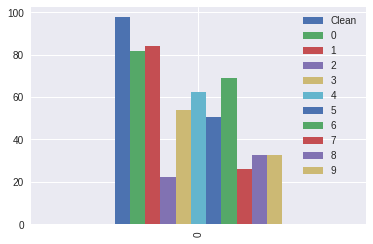

In [93]:
act = pd.DataFrame.from_dict(test_accuracy, orient='index')
act.transpose().plot.bar()